Condition number of matrix A: 22717774363.259506
Mean Squared Errors:
Modified Gram-Schmidt: 4.8140254327353385e-14
Householder: 1.2903984199233421e-11
SVD: 4.302015177313305e-14
Normal Equations: 3.134202826887155e-10
Numpy Least Squares: 4.3020144770774706e-14


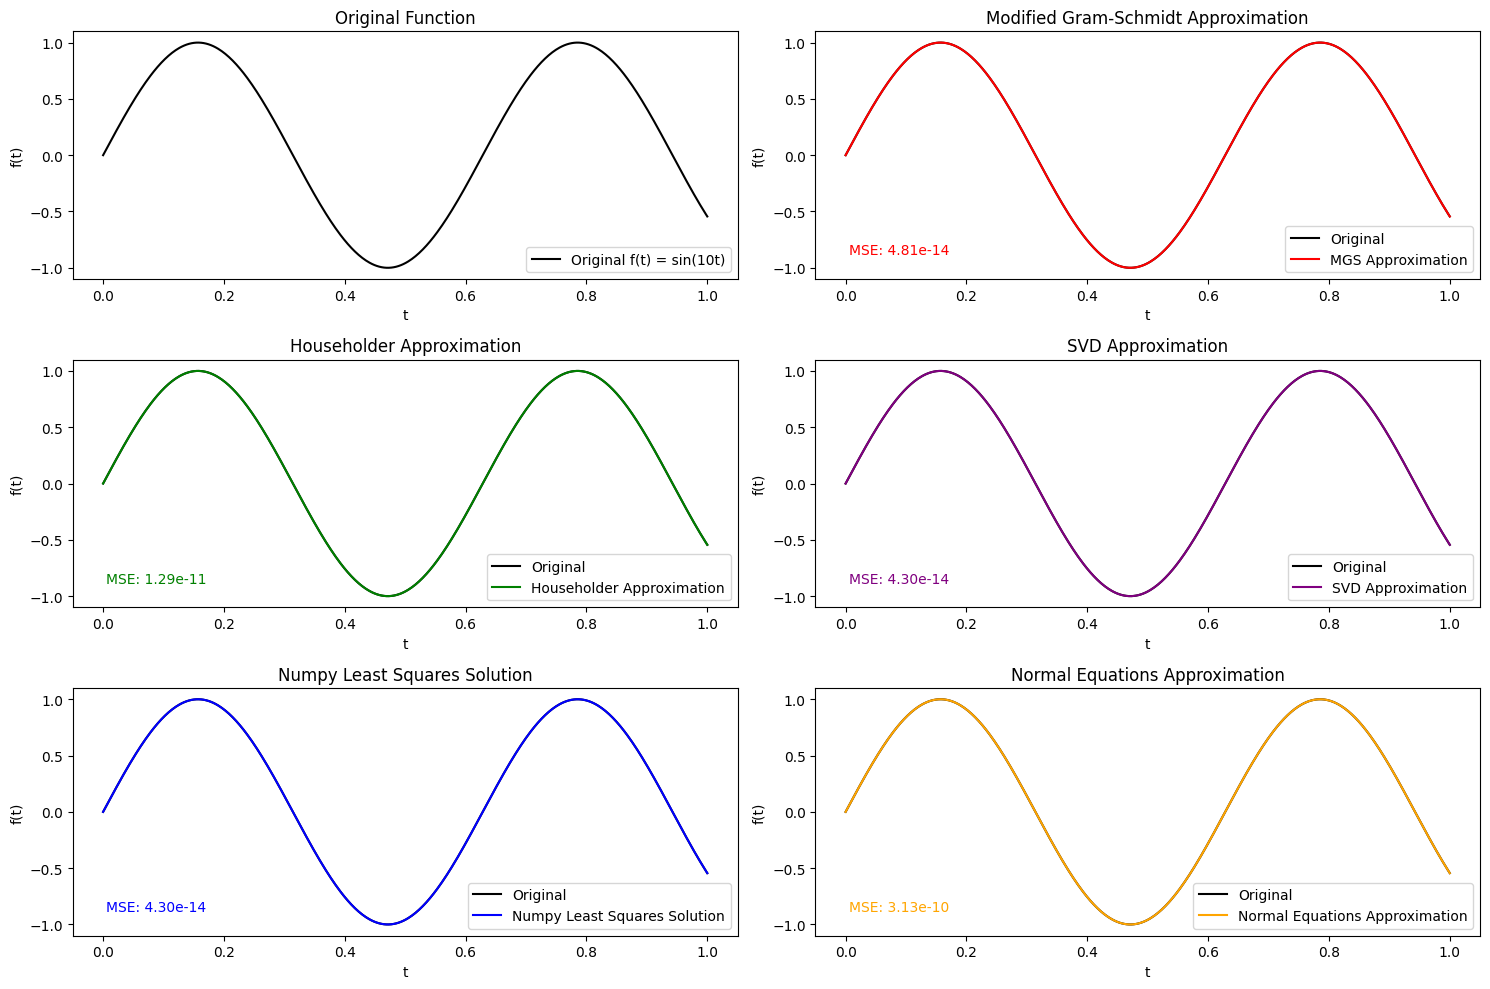

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import qr, svd, lstsq, cond

# Step 1: Generate data points
m = 100
t = np.linspace(0, 1, m)
f_t = np.sin(10 * t)

# Step 2: Define matrix A for 14th-degree polynomial fit
n = 14
A = np.vander(t, n + 1, increasing=True)

# Step 3: Define each method to solve the least squares

# Method (a): QR Factorization with Modified Gram-Schmidt
def modified_gram_schmidt(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    for j in range(n):
        v = A[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], v)
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    return Q, R

def back_substitution(R, y):
    n = len(y)
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(R[i, i+1:], x[i+1:])) / R[i, i]
    return x

Q_mgs, R_mgs = modified_gram_schmidt(A)
coeffs_mgs = back_substitution(R_mgs, Q_mgs.T @ f_t)

# Method (b): QR Factorization using Householder reflections
def householder_qr(A):
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()
    for i in range(n):
        x = R[i:, i]
        e1 = np.zeros_like(x)
        e1[0] = np.linalg.norm(x) * (-1 if x[0] < 0 else 1)
        u = x + e1
        v = u / np.linalg.norm(u)
        R[i:, :] -= 2 * np.outer(v, v @ R[i:, :])
        Q[i:, :] -= 2 * np.outer(v, v @ Q[i:, :])
    return Q.T, R

Q_house, R_house = householder_qr(A)
coeffs_house = back_substitution(R_house[:n, :n], (Q_house.T @ f_t)[:n])

# Method (c): SVD Solution without back substitution
U, S, Vt = svd(A)
c = U.T @ f_t  # Project f_t onto U
c = c[:len(S)] / S  # Divide by singular values
coeffs_svd = Vt.T @ c  # Project back to the original space

# Method (d): Normal Equations
AtA = A.T @ A
Atb = A.T @ f_t
coeffs_normal = np.linalg.solve(AtA, Atb)

# "True" solution using numpy's least-squares function
coeffs_true, _, _, _ = lstsq(A, f_t, rcond=None)

# Step 4: Compute Condition Number
cond_num = cond(A)
print("Condition number of matrix A:", cond_num)

# Step 5: Plot results for each method and calculate errors
t_dense = np.linspace(0, 1, 500)
f_t_dense = np.sin(10 * t_dense)
f_mgs = np.polyval(coeffs_mgs[::-1], t_dense)
f_house = np.polyval(coeffs_house[::-1], t_dense)
f_svd = np.polyval(coeffs_svd[::-1], t_dense)
f_normal = np.polyval(coeffs_normal[::-1], t_dense)
f_true = np.polyval(coeffs_true[::-1], t_dense)

# Calculate Mean Squared Error (MSE) for each method
mse_mgs = np.mean((f_t_dense - f_mgs) ** 2)
mse_house = np.mean((f_t_dense - f_house) ** 2)
mse_svd = np.mean((f_t_dense - f_svd) ** 2)
mse_normal = np.mean((f_t_dense - f_normal) ** 2)
mse_true = np.mean((f_t_dense - f_true) ** 2)

# Print MSE for each method
print("Mean Squared Errors:")
print(f"Modified Gram-Schmidt: {mse_mgs}")
print(f"Householder: {mse_house}")
print(f"SVD: {mse_svd}")
print(f"Normal Equations: {mse_normal}")
print(f"Numpy Least Squares: {mse_true}")

# Create subplots and annotate errors
plt.figure(figsize=(15, 10))

# Original function plot
plt.subplot(3, 2, 1)
plt.plot(t_dense, f_t_dense, label="Original f(t) = sin(10t)", color="black")
plt.title("Original Function")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend(loc = "lower right")

# Modified Gram-Schmidt plot
plt.subplot(3, 2, 2)
plt.plot(t_dense, f_t_dense, label="Original", color="black")
plt.plot(t_dense, f_mgs, label="MGS Approximation", color="red")
plt.title("Modified Gram-Schmidt Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend(loc = "lower right")
plt.annotate(f"MSE: {mse_mgs:.2e}", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=10, color="red")

# Householder Reflections plot
plt.subplot(3, 2, 3)
plt.plot(t_dense, f_t_dense, label="Original", color="black")
plt.plot(t_dense, f_house, label="Householder Approximation", color="green")
plt.title("Householder Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend(loc = "lower right")
plt.annotate(f"MSE: {mse_house:.2e}", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=10, color="green")

# SVD-based Solution plot
plt.subplot(3, 2, 4)
plt.plot(t_dense, f_t_dense, label="Original", color="black")
plt.plot(t_dense, f_svd, label="SVD Approximation", color="purple")
plt.title("SVD Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend(loc = "lower right")
plt.annotate(f"MSE: {mse_svd:.2e}", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=10, color="purple")

# Numpy's Least Squares Solution plot
plt.subplot(3, 2, 5)
plt.plot(t_dense, f_t_dense, label="Original", color="black")
plt.plot(t_dense, f_true, label="Numpy Least Squares Solution", color="blue")
plt.title("Numpy Least Squares Solution")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend(loc = "lower right")
plt.annotate(f"MSE: {mse_true:.2e}", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=10, color="blue")

# Normal Equations plot
plt.subplot(3, 2, 6)
plt.plot(t_dense, f_t_dense, label="Original", color="black")
plt.plot(t_dense, f_normal, label="Normal Equations Approximation", color="orange")
plt.title("Normal Equations Approximation")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.legend(loc="lower right")
plt.annotate(f"MSE: {mse_normal:.2e}", xy=(0.05, 0.1), xycoords='axes fraction', fontsize=10, color="orange")

plt.tight_layout()
plt.show()
